In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import patsy
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from lifelines.utils import datetimes_to_durations
from lifelines import CoxPHFitter
%matplotlib inline

In [2]:
sample = pd.read_table('/psych/genetics_data/ccarey/UKBB/ukb_files/ukb_whitebritish.txt',sep=" ",index_col="IID")
with open("/stanley/genetics/datasets/ukb31063/ukb31063.withdrawn_participants.20210809.csv","r") as f:
        withdraw = f.read().split()
final_sample = np.setdiff1d(sample.index,withdraw)

In [3]:
rawcols_baseline = pd.read_table('/stanley/robinson/ccarey/UKBB/ukb_files/ukb31063.raw_phenotypes.tsv',nrows=0)

In [4]:
mycols_baseline = ["eid","53-0.0",'21003-0.0','105010-0.0', '105010-1.0', '105010-2.0', '105010-3.0', '105010-4.0','20400-0.0','22500-0.0','3894-0.0',"3992-0.0","3627-0.0","2966-0.0","3786-0.0","3761-0.0","2976-0.0","4689-0.0","4700-0.0","5945-0.0","20433-0.0"]

In [5]:
mycol_labels_baseline = ["sample", "age_at_baseline","date_baseline","date_diet1","date_diet2","date_diet3","date_diet4","date_mhq","date_work","age_heartattack","age_emphysema","age_angina","age_hypertension","age_asthma","age_hayfever","age_diabetes","age_glaucoma","age_cataract","age_eyeother","age_depression_mhq"]

In [6]:
coldict_baseline = dict(zip(mycols_baseline,mycol_labels_baseline))

In [7]:
raw_baseline = pd.read_table('/stanley/robinson/ccarey/UKBB/ukb_files/ukb31063.raw_phenotypes.tsv',usecols=mycols_baseline,index_col="eid",dtype=object)

In [8]:
mycols_birth = ["eid","34-0.0","52-0.0"]

In [9]:
mycol_labels_birth = ["sample", "birth_year", "birth_month"]

In [10]:
coldict_birth = dict(zip(mycols_birth,mycol_labels_birth))

In [11]:
birth = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/mortality/ukb41114.csv',usecols=mycols_birth,index_col="eid")

In [12]:
death = pd.read_table('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/mortality/ukb31063.death.20211215.txt',usecols=["eid","dsource","date_of_death"],index_col="eid")

In [13]:
dates_raw=raw_baseline[["53-0.0","105010-0.0","105010-1.0","105010-2.0","105010-3.0","105010-4.0","20400-0.0","22500-0.0"]]

In [14]:
dates = dates_raw.apply(lambda x: pd.to_datetime(x).dt.date,axis=1)

In [15]:
t0array = pd.DataFrame(dates.apply(lambda x: [y for y in list(x[:]) if not pd.isna(y)],axis=1))

In [16]:
t0array["t0"] = t0array[0].apply(lambda x: max(x))

In [17]:
covs = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/to_gwas/full_covs.csv",sep=",",index_col="userId")
covs.isFemale = covs.isFemale.astype(int)

In [18]:
fs_rescored = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/PHEWAS/mortality/FS_newcode_full_semifinal_ind_rescored.csv').set_index("s")

In [19]:
fs_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/FS_newcode_full_semifinal_ind.csv').set_index("s")
#wt_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/WLSweight_newcode_full_semifinal_ind.csv').set_index("s")
misscor_ind = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/semifinalfullind/MissCor_newcode_full_semifinal_ind.csv').set_index("s")

In [20]:
fs_dep = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/FS_newcode_full_semifinal.csv').set_index("s")
wt_dep = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/WLSweight_newcode_full_semifinal.csv').set_index("s")
misscor_dep = pd.read_csv('/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/MissCor_newcode_full_semifinal.csv').set_index("s")

In [21]:
fs_rescored[misscor_ind<np.sqrt(0.8)] = np.nan
fs_rescored[misscor_dep<np.sqrt(0.8)] = np.nan
fs_rescored.f27[misscor_dep.f27<np.sqrt(0.9)] = np.nan
fs_rescored[fs_dep.isna()] = np.nan

In [22]:
fulldata = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/newcode/full_data_rescoredt0.csv").set_index("userId")

In [23]:
zscore = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/compare_zscore/f23_z.csv").set_index("userId")

In [24]:
htn_compare = pd.DataFrame(fs_rescored["f23"]).join(zscore,how="inner").join(fulldata[["904","884","864","6164_3","6164_2","6160_1","1060","6162_4","894","1050"]],how="inner").dropna()

In [25]:
to_analyze_htn = htn_compare.join(covs,how="left").join(birth,how="left").join(death,how="left").join(raw_baseline,how="left").join(t0array["t0"],how="left")

In [26]:
mycovs = covs.columns[:21].tolist() + covs.columns[27:].tolist()

In [27]:
to_analyze_htn = htn_compare.join(covs,how="left").join(birth,how="left").join(death,how="left").join(raw_baseline,how="left").join(t0array["t0"],how="left")
to_analyze_htn["start"] = pd.to_datetime(to_analyze_htn["t0"])
to_analyze_htn["end"] = pd.to_datetime(to_analyze_htn["date_of_death"],format='%d/%m/%Y')
to_analyze_htn = to_analyze_htn[~((to_analyze_htn.end - to_analyze_htn.start).dt.days<0)]
T, E = datetimes_to_durations(to_analyze_htn.start, to_analyze_htn.end,fill_date=datetime.datetime(2021, 9, 30))
to_analyze_htn["T"] = T
to_analyze_htn["E"] = E
to_analyze_htn["date_baseline"] = pd.to_datetime(to_analyze_htn["53-0.0"])
to_analyze_htn["days_from_baseline"] = (to_analyze_htn.start - to_analyze_htn.date_baseline).dt.days
formodel = to_analyze_htn[mycovs+["days_from_baseline","T","E"]]
formodel = formodel[formodel.columns[formodel.var()!=0]]
cph = CoxPHFitter()
temp = cph.fit(formodel, 'T', event_col='E')
logtest = -2 * (cph._ll_null_ - cph.log_likelihood_)
rsq = 1 - np.exp(-logtest/cph._n_examples)
maxrsq = 1 - np.exp(2 * cph._ll_null_/cph._n_examples)
baseliner2=rsq
print(rsq,maxrsq)

/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


0.03608761534772076 0.8074005256856194


In [71]:
items = ["f23","904","884","864","6164_3","6164_2","6160_1","1060","6162_4","894","1050","f23_z"]
outframe = pd.DataFrame(index=items, columns=["inc_r2"])
for item in items:
    to_analyze_htn = htn_compare.join(covs,how="left").join(birth,how="left").join(death,how="left").join(raw_baseline,how="left").join(t0array["t0"],how="left")
    to_analyze_htn["start"] = pd.to_datetime(to_analyze_htn["t0"])
    to_analyze_htn["end"] = pd.to_datetime(to_analyze_htn["date_of_death"],format='%d/%m/%Y')
    to_analyze_htn = to_analyze_htn[~((to_analyze_htn.end - to_analyze_htn.start).dt.days<0)]
    T, E = datetimes_to_durations(to_analyze_htn.start, to_analyze_htn.end,fill_date=datetime.datetime(2021, 9, 30))
    to_analyze_htn["T"] = T
    to_analyze_htn["E"] = E
    to_analyze_htn["date_baseline"] = pd.to_datetime(to_analyze_htn["53-0.0"])
    to_analyze_htn["days_from_baseline"] = (to_analyze_htn.start - to_analyze_htn.date_baseline).dt.days
    formodel = to_analyze_htn[[item]+mycovs+["days_from_baseline","T","E"]]
    formodel = formodel[formodel.columns[formodel.var()!=0]]
    cph = CoxPHFitter()
    temp = cph.fit(formodel, 'T', event_col='E')
    logtest = -2 * (cph._ll_null_ - cph.log_likelihood_)
    rsq = 1 - np.exp(-logtest/cph._n_examples)
    maxrsq = 1 - np.exp(2 * cph._ll_null_/cph._n_examples)
    outframe.loc[item,"inc_r2"] = rsq-baseliner2
    print(item,"{:e}".format(rsq-baseliner2), formodel[~formodel.isnull().any(axis=1)].shape[0])
    # temp.print_summary()

/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f23 1.273393e-03 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


904 4.334524e-04 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


884 2.372293e-05 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


864 1.037691e-04 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


6164_3 6.100043e-04 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


6164_2 1.118763e-03 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


6160_1 6.722977e-04 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


1060 2.259313e-05 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


6162_4 1.458809e-04 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


894 1.655790e-04 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


1050 6.747931e-10 217393


/home/unix/rwalters/py39haillibs/lib/python3.9/site-packages/lifelines/utils/__init__.py:1102: ConvergenceWarning: Column(s) ['PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC2', 'PC20', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


f23_z 9.959917e-04 217393


In [29]:
all_h2_rg = pd.read_table("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/FINAL/all_h2_rg.tsv",index_col="factor")

In [30]:
cfafactors = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/TRAINING/redux10point2/for_jupyter/loadings.txt",sep="\t")

In [31]:
factordict = cfafactors.groupby('factor')["item "].apply(lambda x: x.tolist()).to_dict()

In [32]:
nealeh2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/ukb31063_h2_all.02Oct2019.tsv.gz", sep="\t")

/local/scratch/41710693.1.interactive/ipykernel_204065/135564914.py:1: DtypeWarning: Columns (2,792) have mixed types. Specify dtype option on import or set low_memory=False.
  nealeh2 = pd.read_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/FACTOR_SCORES/core/wls_gwas/ukb31063_h2_all.02Oct2019.tsv.gz", sep="\t")


In [33]:
nealeh2_bothsexes = nealeh2[nealeh2.sex=="both_sexes"]
nealeh2_bothsexes_dropirnt = nealeh2_bothsexes[~(nealeh2_bothsexes.variable_type=="continuous_irnt")]
nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.phenotype.apply(lambda x: "_raw" in x),"phenotype"] = nealeh2_bothsexes_dropirnt[nealeh2_bothsexes_dropirnt.phenotype.apply(lambda x: "_raw" in x)].phenotype.apply(lambda x: x.split("_")[0])
nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.source=="icd10","phenotype"] = nealeh2_bothsexes_dropirnt.loc[nealeh2_bothsexes_dropirnt.source=="icd10"].phenotype.apply(lambda x: "41202_"+x)

In [34]:
cfaitems = cfafactors["item "].values
cfaitems = [x[1:] for x in cfaitems]

In [35]:
nealeh2_items = nealeh2_bothsexes_dropirnt[nealeh2_bothsexes_dropirnt.phenotype.isin(cfaitems)]

In [36]:
nealeh2_items_only = nealeh2_items[["phenotype","h2_observed","h2_observed_se","Neff"]].set_index("phenotype")

In [37]:
all_h2_rg["h2_lower"] = all_h2_rg["h2_full"]-all_h2_rg["h2_se_full"]
all_h2_rg["h2_upper"] = all_h2_rg["h2_full"]+all_h2_rg["h2_se_full"]
all_h2_rg["h2"] = all_h2_rg["h2_full"]

In [38]:
cfafactors["abs_loading"] = abs(cfafactors["loading"])
cfafactors = cfafactors.sort_values(["factor","abs_loading"],ascending=[True,False])
cfafactors["orderednum"] = cfafactors.groupby('factor').cumcount().add(1)
cfafactors["item"] = cfafactors.apply(lambda x: x["item "][1:],axis=1)
cfafactors = cfafactors.drop("item ",axis=1)
cfafactors = cfafactors[cfafactors.orderednum<=10]

In [39]:
phenoNames = pd.read_csv("/psych/genetics_data/ccarey/UKBB/factor_gwas/core_data_group/FA_core_FieldNames.csv",index_col="Unnamed: 0")

phenolabels = pd.Series(phenoNames["name"],index=phenoNames.index).to_dict()

In [40]:
for factor in ["f23"]:
    #print(factor)
    cfafac = cfafactors.loc[cfafactors["factor"]==factor]
    cfafac["h2"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed"])
    cfafac["h2_se"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed_se"])
    cfafac["h2_lower"] = cfafac.h2-cfafac.h2_se
    cfafac["h2_upper"] = cfafac.h2+cfafac.h2_se
    
    toplot = cfafac[["item","h2","h2_lower","h2_upper"]]
    toplotfactor = pd.DataFrame(columns=["item ","h2","h2_lower","h2_upper"])
    toplotfactor = toplotfactor.append({"item" : "f23", "h2" : all_h2_rg.loc[factor,"h2"], "h2_lower" : all_h2_rg.loc[factor,"h2_lower"], "h2_upper" : all_h2_rg.loc[factor,"h2_upper"]},ignore_index=True)

    toplotz = pd.DataFrame(columns=["item ","h2","h2_lower","h2_upper"])
    zh2 = 0.05
    zse = 0.004
    toplotz = toplotz.append({"item" : "f23_z", "h2" : zh2, "h2_lower" : zh2-zse, "h2_upper" : zh2+zse},ignore_index=True)
     
    toplot = pd.concat([toplotfactor,toplotz, toplot]).reset_index(drop=True).set_index("item")   

    toplot["y"] = list(range(1,toplot.shape[0]+1))[::-1]
    toplot["color"] = "orange"
    toplot.loc["f23","color"]="blue"
    toplot.loc["f23_z","color"]="red"

/local/scratch/41710693.1.interactive/ipykernel_204065/183396293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfafac["h2"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed"])
/local/scratch/41710693.1.interactive/ipykernel_204065/183396293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cfafac["h2_se"] = cfafac["item"].apply(lambda x: nealeh2_items_only.loc[x,"h2_observed_se"])
/local/scratch/41710693.1.interactive/ipykernel_204065/183396293.py:6: SettingWithCopyWarning: 
A 

In [41]:
toplot = toplot.join(outframe)

In [42]:
import matplotlib.gridspec as gridspec

In [43]:
prs_results = pd.read_csv("/stanley/robinson/ccarey/factor_paper_revision/prs_results/physed.tsv",sep="\t")

In [44]:
dfp = prs_results.pivot(index='trait', columns='PRS', values='r2')*100

In [45]:
col_order = ["Factor 23","Days/week vigorous physical activity 10+ minutes","Days/week moderate physical activity 10+ minutes","Days/week walked 10+ minutes","Strenuous sports in last 4 weeks","Other physical activities in last 4 weeks","Sports club or gym","Time outdoors in winter","Cycling for transportation","Duration of moderate activity","Time outdoors in summer"]
index_order = ["Hours of Physical Activity Per Week","BMI","Blood Pressure","Diabetes","Cardiovascular Disease"][::-1]
dfp = dfp.loc[index_order,col_order]

In [46]:
dfp = dfp.T[0:4][::-1]

In [47]:
yerr_lower = prs_results.pivot(index='trait', columns='PRS', values='lower')*100
yerr_lower = dfp-yerr_lower.T.loc[col_order[0:4][::-1],index_order]

In [48]:
yerr_upper = prs_results.pivot(index='trait', columns='PRS', values='upper')*100
yerr_upper = yerr_upper.T.loc[col_order[0:4][::-1],index_order]-dfp

In [59]:
err = []
for col in yerr_lower:  # Iterate over bar groups (represented as columns)
    err.append([yerr_lower[col].values, yerr_upper[col].values])

In [62]:
toplot.to_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/notebooks/fig6_interim/toplot.csv")
dfp.to_csv("/stanley/robinson/ccarey/UKBB/factor_gwas/factor_analysis/cfa/FINAL_CFA/notebooks/fig6_interim/dfp.csv")
err

TypeError: to_csv() got an unexpected keyword argument 'index_col'

/local/scratch/41710693.1.interactive/ipykernel_204065/3362858056.py:45: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/figures_RKWchecklist/Figure6_journal_RKW.pdf",bbox_inches="tight",format="pdf")
/local/scratch/41710693.1.interactive/ipykernel_204065/3362858056.py:45: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/figures_RKWchecklist/Figure6_journal_RKW.pdf",bbox_inches="tight",format="pdf")
/broad/software/free/Linux/redhat_7_x86_64/pkgs/anaconda3_2022.10/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


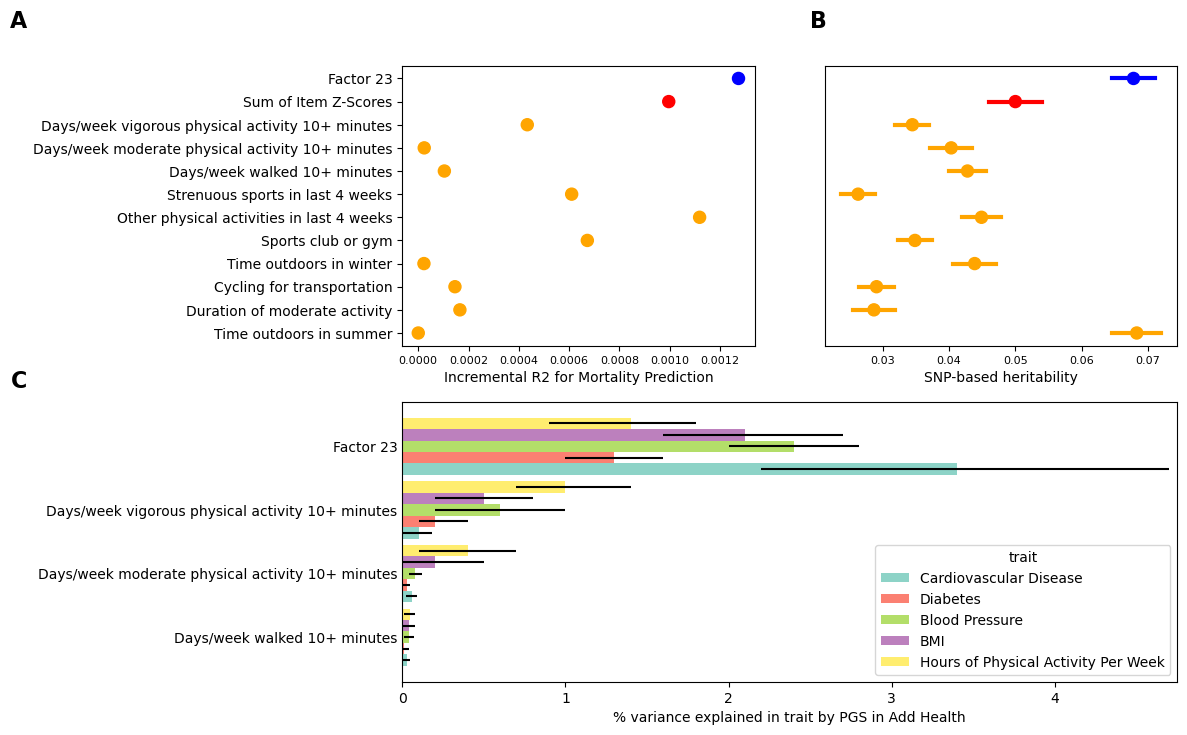

In [50]:
#fig, ax = plt.subplots(figsize=(6,5))
fig = plt.figure(figsize=(10,8),constrained_layout=True)
gs = gridspec.GridSpec(2, 2,width_ratios=[1,1])

ax = plt.subplot(gs[0,0])

plt.scatter(x=toplot.inc_r2,y=toplot.y,color=toplot.color, s=75)
ylabels = col_order[1:][::-1] + ["Sum of Item Z-Scores","Factor 23"]
plt.yticks(range(1,len(toplot.h2)+1), ylabels,fontsize=10)
plt.xticks(fontsize=8)
plt.xlabel("Incremental R2 for Mortality Prediction",fontsize=10)

ax = plt.subplot(gs[0,1])

plt.scatter(x=toplot.h2,y=toplot.y,color=toplot.color, s=75)
ylabels = col_order[1:][::-1] + ["Sum of Item Z-Scores","Factor 23"]
plt.yticks(range(1,len(toplot.h2)+1), ylabels,fontsize=10)
plt.xticks(fontsize=8)
for item in toplot.index:
    lower = toplot.loc[item,"h2_lower"]
    upper = toplot.loc[item,"h2_upper"]
    yval = toplot.loc[item,"y"]
    plt.plot([lower,upper],[yval,yval],color=toplot.loc[item,"color"],linewidth=3)
plt.xlabel("SNP-based heritability",fontsize=10)
plt.gca().yaxis.set_visible(False)

ax = plt.subplot(gs[1,:])

#dfp.plot(kind="barh",xerr=err,cmap=plt.get_cmap("Set3"),width=0.9,ax=ax)
dfp.plot(kind="barh",xerr=np.asarray(err),cmap=plt.get_cmap("Set3"),width=0.9,ax=ax)
plt.gca().set_ylabel("")
plt.gca().set_xlabel("% variance explained in trait by PGS in Add Health")
plt.gca().set_xlim([0,4.75])
plt.gca().yaxis.set_tick_params(length=0)
plt.setp(plt.gca().get_xticklabels(), rotation=0, horizontalalignment='center')
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

fig.text(-0.25,0.95, "A", 
      fontsize=16, fontweight='bold', va='top', ha='right')
fig.text(0.55,0.95, "B", 
      fontsize=16, fontweight='bold', va='top', ha='right')
fig.text(-0.25,0.5, "C", 
      fontsize=16, fontweight='bold', va='top', ha='right')

plt.savefig("/stanley/robinson/ccarey/factor_paper_revision/figures_RKWchecklist/Figure6_journal_RKW.pdf",bbox_inches="tight",format="pdf")

In [ ]:
dfp.plot(kind="barh",xerr=np.asarray(err),cmap=plt.get_cmap("Set3"),width=0.9)
plt.gca().set_xlim([0,5])
plt.gca().yaxis.set_tick_params(length=0)
plt.gca().set_ylabel("")

In [57]:
np.asarray(err)

array([[[0.05, 0.04, 0.1 , 1.2 ],
        [0.02, 0.03, 0.08, 1.3 ]],

       [[0.04, 0.04, 0.1 , 0.3 ],
        [0.03, 0.02, 0.2 , 0.3 ]],

       [[0.03, 0.04, 0.4 , 0.4 ],
        [0.03, 0.04, 0.4 , 0.4 ]],

       [[0.05, 0.2 , 0.3 , 0.5 ],
        [0.04, 0.3 , 0.3 , 0.6 ]],

       [[0.04, 0.3 , 0.3 , 0.5 ],
        [0.03, 0.3 , 0.4 , 0.4 ]]])

In [64]:
nealeh2_items.loc[nealeh2_items.phenotype.isin(items),]

,phenotype,sex,dilute,gwas_file,variable_type,n_missing,source,description,n,n_cases,...,isBadPower,isLowNeff,isMidNeff,isExtremeSE,isHighSE,isSexBias,isBadOrdinal,isNumericOrdinal,conf_simple,h2_sig
129,1050,both_sexes,NaN,1050.gwas.imputed_v3.both_sexes.tsv.bgz,ordinal,33477,phesant,Time spend outdoors in summer,327717,NaN,...,False,False,False,False,False,False,False,False,high,z7
130,1060,both_sexes,NaN,1060.gwas.imputed_v3.both_sexes.tsv.bgz,ordinal,76305,phesant,Time spent outdoors in winter,284889,NaN,...,False,False,False,False,False,False,False,False,high,z7
3214,6160_1,both_sexes,NaN,6160_1.gwas.imputed_v3.both_sexes.tsv.bgz,binary,1131,phesant,Leisure/social activities: Sports club or gym,360063,108473.0,...,False,False,False,False,False,False,False,False,high,z7
3224,6162_4,both_sexes,NaN,6162_4.gwas.imputed_v3.both_sexes.tsv.bgz,binary,1870,phesant,Types of transport used (excluding work): Cycle,359324,26059.0,...,False,False,False,False,False,False,False,False,high,z7
3227,6164_2,both_sexes,NaN,6164_2.gwas.imputed_v3.both_sexes.tsv.bgz,binary,1931,phesant,Types of physical activity in last 4 weeks: Ot...,359263,174242.0,...,False,False,False,False,False,False,False,False,high,z7
3228,6164_3,both_sexes,NaN,6164_3.gwas.imputed_v3.both_sexes.tsv.bgz,binary,1931,phesant,Types of physical activity in last 4 weeks: St...,359263,37297.0,...,False,False,False,False,False,False,False,False,high,z7
3272,864,both_sexes,NaN,864.gwas.imputed_v3.both_sexes.tsv.bgz,ordinal,6164,phesant,Number of days/week walked 10+ minutes,355030,NaN,...,False,False,False,False,False,False,False,False,high,z7
3275,884,both_sexes,NaN,884.gwas.imputed_v3.both_sexes.tsv.bgz,ordinal,17251,phesant,Number of days/week of moderate physical activ...,343943,NaN,...,False,False,False,False,False,False,False,False,high,z7
3276,894,both_sexes,NaN,894.gwas.imputed_v3.both_sexes.tsv.bgz,ordinal,92368,phesant,Duration of moderate activity,268826,NaN,...,False,False,False,False,False,False,False,False,high,z7
3277,904,both_sexes,NaN,904.gwas.imputed_v3.both_sexes.tsv.bgz,ordinal,17110,phesant,Number of days/week of vigorous physical activ...,344084,NaN,...,False,False,False,False,False,False,False,False,high,z7


In [69]:
formodel[~formodel.isnull().any(axis=1)].shape[0]

217393